# Setup

In [1]:
!git clone https://github.com/Sopralapanca/medium-skill-based-agents.git
%cd /content/medium-skill-based-agents
!ls

Cloning into 'medium-skill-based-agents'...
remote: Enumerating objects: 9114, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 9114 (delta 0), reused 1 (delta 0), pack-reused 9111 (from 1)
Receiving objects: 100% (9114/9114), 47.03 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (2376/2376), done.
Updating files: 100% (4886/4886), done.
/content/medium-skill-based-agents
 agents				    pyproject.toml     test_packages.py
 create_dataset.py		    README.md	       train_usr.py
 data				    requirements.txt   train_vok.py
 main.py			    roms	       train_vos.py
'[Medium]Skilled_RL_Agents.ipynb'   skills	       uv.lock


In [2]:
!uv --version

uv 0.9.16


In [ ]:
%pip uninstall gym

In [3]:
!uv pip install -r pyproject.toml

Using Python 3.12.12 environment at: /usr
Resolved 111 packages in 3.09s
Prepared 25 packages in 1m 09s
Uninstalled 19 packages in 1.80s
Installed 25 packages in 794ms
 + atariari==0.0.1 (from git+https://github.com/Sopralapanca/atari-representation-learning.git@6ef260a81915eee0c0d1bd99da70e80300799c7b)
 - gymnasium==1.2.2
 + gymnasium==1.2.3
 + huggingface-sb3==3.0
 + kornia==0.8.2
 + kornia-rs==0.1.10
 - moviepy==1.0.3
 + moviepy==2.2.1
 - nvidia-cublas-cu12==12.6.4.1
 + nvidia-cublas-cu12==12.8.4.1
 - nvidia-cuda-cupti-cu12==12.6.80
 + nvidia-cuda-cupti-cu12==12.8.90
 - nvidia-cuda-nvrtc-cu12==12.6.77
 + nvidia-cuda-nvrtc-cu12==12.8.93
 - nvidia-cuda-runtime-cu12==12.6.77
 + nvidia-cuda-runtime-cu12==12.8.90
 - nvidia-cufft-cu12==11.3.0.4
 + nvidia-cufft-cu12==11.3.3.83
 - nvidia-cufile-cu12==1.11.1.6
 + nvidia-cufile-cu12==1.13.1.3
 - nvidia-curand-cu12==10.3.7.77
 + nvidia-curand-cu12==10.3.9.90
 - nvidia-cusolver-cu12==11.7.1.2
 + nvidia-cusolver-cu12==11.7.3.90
 - nvidia-cuspars

In [5]:
!python create_dataset.py

2025-12-20 08:20:38.823041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
Starting gameplay for 100 episodes...
Using random agent (no model provided)
100% 100/100 [00:07<00:00, 13.30it/s]
Frames saved to ./data/BreakoutNoFrameskip-v4_random
Starting gameplay for 100 episodes...
ppo-BreakoutNoFrameskip-v4.zip: 100% 20

In [7]:
!python train_usr.py

2025-12-20 08:33:18.628170: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]
-------Collecting samples----------
Deleting block_bit_map_0 for being too low in entropy! Sorry, dood!
Deleting block_bit_map_1 for being too low in entropy! Sorry, dood!
Deleting block_bit_map_2 for being too low in entropy! Sorry, dood!
Delet

# Dataset Creation

# Skills



## Video Object Segmentation

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from kornia.losses import ssim_loss

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class VideoObjectSegmentationModel(nn.Module):
    def __init__(self, device="cpu", emb_size=512, K=20, depth=24, H=84, W=84):
        super().__init__()
        self.device = device

        self.of_reg_cur = 0.0
        self.of_reg_inc = 1e-5
        self.emb_size = emb_size
        self.K = K
        self.depth = depth
        self.H = H
        self.W = W
        self.final_conv_size = 7 * 7 * 64
        self.flow_c = 0.01

        self.cnn = nn.Sequential(
            nn.Conv2d(2, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            Flatten()
        )
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc_conv = nn.Linear(self.final_conv_size, emb_size)

        self.obj_trans = nn.Linear(emb_size, self.K*2)
        self.cam_trans = nn.Linear(emb_size, 2)

        self.fc_m1 = nn.Linear(emb_size, 21*21*self.depth)
        self.conv_m1 = nn.Conv2d(self.depth, self.depth, 3, 1, 1)
        self.conv_m2 = nn.Conv2d(self.depth, self.depth, 3, 1, 1)
        self.conv_m3 = nn.Conv2d(self.depth, self.K, 1, 1)
        self.upsample1 = nn.UpsamplingBilinear2d(size=(42, 42))
        self.upsample2 = nn.UpsamplingBilinear2d(size=(84, 84))

    def compute_masks(self, input):
        # input shape = [ BS x C x H x W ]

        # Basic CNN
        x = self.cnn(input)
        x = self.relu(self.fc_conv(x))

        # Object Masks
        m = self.fc_m1(x)
        m = m.view((-1, self.depth, 21, 21))
        m = self.upsample1(m)

        # conv 5
        y = self.conv_m1(m)      # padding=1 => padding='same'
        m = self.relu(m + y)
        m = self.upsample2(m)

        # conv 6
        z = self.conv_m2(m)
        m = self.relu(m + z)

        # [ BS x K x H x W ]
        m = self.conv_m3(m)
        m = self.sigmoid(m)

        return m

    def forward(self, input):
        # input shape = [ BS x C x H x W ]

        # Basic CNN
        x = self.cnn(input)
        x = self.relu(self.fc_conv(x))

        # Object Masks
        m = self.fc_m1(x)
        m = m.view((-1, self.depth, 21, 21))
        m = self.upsample1(m)

        # conv 5
        y = self.conv_m1(m)      # padding=1 => padding='same'
        m = self.relu(m + y)
        m = self.upsample2(m)

        # conv 6
        z = self.conv_m2(m)
        m = self.relu(m + z)

        # [ BS x K x H x W ]
        m = self.conv_m3(m)
        m = self.sigmoid(m)
        self.object_masks = m

        # Object Translation
        ot = self.obj_trans(x)
        # [ BS x K x 2 ]
        ot = torch.reshape(ot, (-1, self.K, 2))

        # Mesh Grid
        mesh_grid = self._create_mesh_grid().to(self.device)

        # Optical Flow
        # [ BS x K x 1 x H x W ]
        m_reshape = torch.unsqueeze(m, 2)

        # [ BS x K x 2 x 1 x 1 ]
        ot_reshape = torch.unsqueeze(torch.unsqueeze(ot, -1), -1)

        translation_masks = m_reshape * ot_reshape
        self.translation_masks = translation_masks

        # [ BS x 2 x H x W ]
        flow = torch.sum(translation_masks, 1)

        # [ BS x 2 x H*W ]
        flat_flow = torch.reshape(flow, (-1, 2, self.W*self.H))

        # Camera Translation
        # [ BS x 2 ]
        ct = self.cam_trans(x)
        ct = torch.unsqueeze(ct, -1)

        # add camera translation to flow
        # [ BS x 2 x H*W ]
        flat_flow = flat_flow + ct

        # Add in the default coordinates
        img_size_f = torch.from_numpy(self.flow_c * np.array([[self.H], [self.W]], dtype=np.float32)).to(self.device)
        img_size_flat_flow = img_size_f * flat_flow

        # [ BS x 2 x H*W]
        sampling_coords = torch.add(img_size_flat_flow, mesh_grid)

        # Computer transformed image
        y_s = sampling_coords[:, 0, :]
        ys_flat = torch.reshape(y_s, (-1,))

        x_s = sampling_coords[:, 1, :]
        xs_flat = torch.reshape(x_s, (-1,))

        # x1 -> x0
        x1 = input[:, 1, :, :]
        source_frames = torch.unsqueeze(x1, 1)

        # Interpolate
        out = self._interpolate(source_frames, xs_flat, ys_flat, (1, self.H, self.W))
        # [ BS x 1 x H x W ]
        out = torch.reshape(out, (input.size(0), 1, self.H, self.W))

        return out

    def compute_loss(self, x, x_):
        # DSSIM
        out_loss = ssim_loss(x, x_, 11)

        # L1 reg for translations masks
        of_loss_reg = torch.abs(self.translation_masks).mean(-1).mean(-1).mean(-1).mean(-1)

        loss = out_loss + self.of_reg_cur * of_loss_reg

        return loss.mean()

    def update_reg(self):
        # increase regularization
        self.of_reg_cur = min(self.of_reg_cur + self.of_reg_inc, 1)

    def _create_mesh_grid(self):
        x_lin = torch.linspace(0., self.W - 1., self.W)
        y_lin = torch.linspace(0., self.H - 1., self.H)

        grid_x, grid_y = torch.meshgrid(x_lin, y_lin)
        # meshgrid -> pytorch != tf :)
        grid_x = grid_x.t()
        grid_y = grid_y.t()

        grid_x = torch.reshape(grid_x, (1, -1))
        grid_y = torch.reshape(grid_y, (1, -1))

        grid = torch.cat([grid_y, grid_x], 0)

        return grid

    def _repeat(self, x, n_rep):
        a = torch.unsqueeze(torch.ones(n_rep, device=self.device), 1)
        rep = a.permute(1, 0)
        x = torch.reshape(x, (-1, 1)).to(torch.float32)
        y = torch.matmul(x, rep)
        y = torch.reshape(y, (-1,))
        return y

    # https://github.com/daviddao/spatial-transformer-tensorflow/blob/master/spatial_transformer.py
    def _interpolate(self, im, x, y, out_size):
        bs, c, h, w = im.shape

        x = x.to(torch.float32)
        y = y.to(torch.float32)
        out_h = out_size[1]
        out_w = out_size[2]
        zero = torch.zeros([], dtype=torch.int32, device=self.device)
        max_y = h - 1
        max_x = w - 1

        # sampling
        x0 = torch.floor(x)
        x0 = x0.to(torch.int32)
        x0 = torch.clamp(x0, zero, max_x)
        unclip_x1 = x0 + 1
        x1 = torch.clamp(unclip_x1, zero, max_x)

        y0 = torch.floor(y)
        y0.to(torch.int32)
        y0 = torch.clamp(y0, zero, max_y)
        unclip_y1 = y0 + 1
        y1 = torch.clamp(unclip_y1, zero, max_y)

        dim2 = w
        dim1 = w*h
        z = torch.arange(0, bs, device=self.device)*dim1
        base = self._repeat(z, out_h*out_w)
        base_y0 = base + y0*dim2
        base_y1 = base + y1*dim2
        idx_a = base_y0 + x0
        idx_b = base_y1 + x0
        idx_c = base_y0 + x1
        idx_d = base_y1 + x1

        # use indices to lookup pixels in the flat image and restore
        im_flat = torch.reshape(im, (-1, c))
        im_flat = im_flat.to(torch.float32)
        Ia = im_flat[idx_a.to(torch.long)]
        Ib = im_flat[idx_b.to(torch.long)]
        Ic = im_flat[idx_c.to(torch.long)]
        Id = im_flat[idx_d.to(torch.long)]

        # unclip_x1 = torch.clamp(unclip_x1, zero, max_x + 1)
        # unclip_y1 = torch.clamp(unclip_y1, zero, max_y + 1)

        x = torch.clamp(x, 0., float(max_x))
        y = torch.clamp(y, 0., float(max_y))

        # calculate interpolated values
        x0_f = x0.to(torch.float32)
        x1_f = x1.to(torch.float32)     # ?
        y0_f = y0.to(torch.float32)
        y1_f = y1.to(torch.float32)     # ?
        wa = torch.unsqueeze((x1_f-x) * (y1_f-y), 1)
        wb = torch.unsqueeze((x1_f-x) * (y-y0_f), 1)
        wc = torch.unsqueeze((x-x0_f) * (y1_f-y), 1)
        wd = torch.unsqueeze((x-x0_f) * (y-y0_f), 1)
        output = wa*Ia + wb*Ib + wc*Ic + wd*Id

        return output

In [ ]:
import numpy as np
import glob
import os
import random
import torch
from PIL import Image
import cv2

class VOSDataset():
    def __init__(self, batch_size, num_frames, data_path, H=84, W=84):
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.H = H
        self.W = W
        self.data_path = data_path
        self.envs = os.listdir(self.data_path)
        self.episodes = {}


        for env in self.envs:
          self.episode_paths = sorted(os.listdir(os.path.join(self.data_path, env)))


          for episode_path in self.episode_paths:
              self.episodes[env+"/"+episode_path] = sorted(
                  glob.glob(os.path.join(self.data_path, env, episode_path, '*.png')),
                  key=lambda x: int(os.path.basename(x).split('.')[0]),
              )



        all_episodes = sorted(
            [key for key in self.episodes.keys() if 'episode_' in key],
            key=lambda s: int(s.split('/')[-1].split('_')[-1])
        )
        split = int(0.8 * len(all_episodes))
        self.train_data_keys = all_episodes[:split]
        self.valid_data_keys = all_episodes[split:]


    def get_batch(self, data_type):
      if data_type == "train":
          episodes_keys = self.train_data_keys
      else:
          episodes_keys = self.valid_data_keys

      episodes = {k: self.episodes[k] for k in episodes_keys}
      valid_keys = [k for k in episodes if len(episodes[k]) >= self.num_frames]

      frames = np.zeros([self.batch_size, self.num_frames, self.H, self.W], dtype=np.float32)

      for bs in range(self.batch_size):
          k = np.random.choice(valid_keys)
          f = episodes[k]
          idx = random.randint(0, len(f) - self.num_frames)

          for j in range(self.num_frames):
              path = f[idx + j]

              # Load image and preprocess: RGB -> Grayscale -> Resize -> Normalize
              img = Image.open(path).convert('RGB')
              img_np = np.array(img)

              # Convert to grayscale
              gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

              # Resize to (84, 84)
              resized = cv2.resize(gray, (self.W, self.H), interpolation=cv2.INTER_AREA)

              # Normalize to [0, 1] and add channel dimension
              x = resized.astype(np.float32) / 255.0

              frames[bs, j, :, :] = x  # (bs, num_frames, H, W)

      return torch.from_numpy(frames).float()

In [ ]:
import numpy as np
import torch
import os
import sys
import random
import torch.nn.functional as F
from tqdm import tqdm

num_frames = 2
batch_size = 32
steps = 1000000
lr = 1e-4
max_grad_norm = 5.0

data = VOSDataset(batch_size, num_frames, data_path)
inp = data.get_batch("train").to(device)


model = VideoObjectSegmentationModel(device=device)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lamb = lambda epoch : 1 - epoch/steps
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lamb)

best_val_loss = 1.
at_step = 0
pbar = tqdm(range(steps), desc="Training")

for i in pbar:
    model.train()
    optimizer.zero_grad()
    inp = data.get_batch("train").to(device)
    x0_ = model(inp)
    x0 = torch.unsqueeze(inp[:, 0, :, :], 1)
    tr_loss = model.compute_loss(x0, x0_)
    tr_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()

    with torch.no_grad():
        model.eval()
        inp = data.get_batch("val").to(device)
        x0_ = model(inp)
        x0 = torch.unsqueeze(inp[:, 0, :, :], 1)
        val_loss = model.compute_loss(x0, x0_)

    model.update_reg()

    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        at_step = i
        #print(f"Step: {i} new best val_loss : {val_loss}")
        torch.save(model.state_dict(), f'./skills/vid-obj-seg.pt')


    last_lr = scheduler.get_last_lr()[0]

    pbar.set_postfix({
        'tr_loss': f'{tr_loss.item():.4f}',
        'val_loss': f'{val_loss.item():.4f}',
        'best_val': f'{best_val_loss:.4f}',
        'at_step': f'{at_step}'
    })


Training:   4%|▎         | 37175/1000000 [1:16:27<33:00:07,  8.10it/s, tr_loss=0.0135, val_loss=0.0123, best_val=0.0023, at_step=27580]


KeyboardInterrupt: 

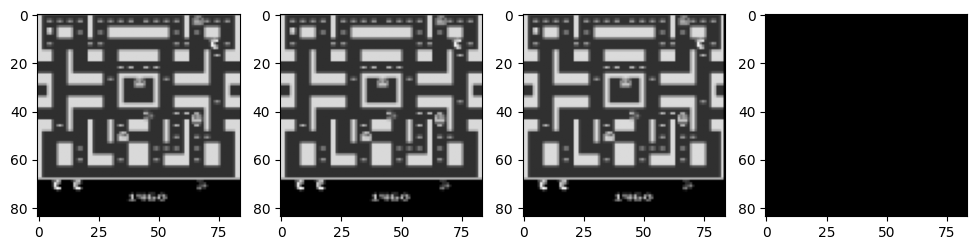

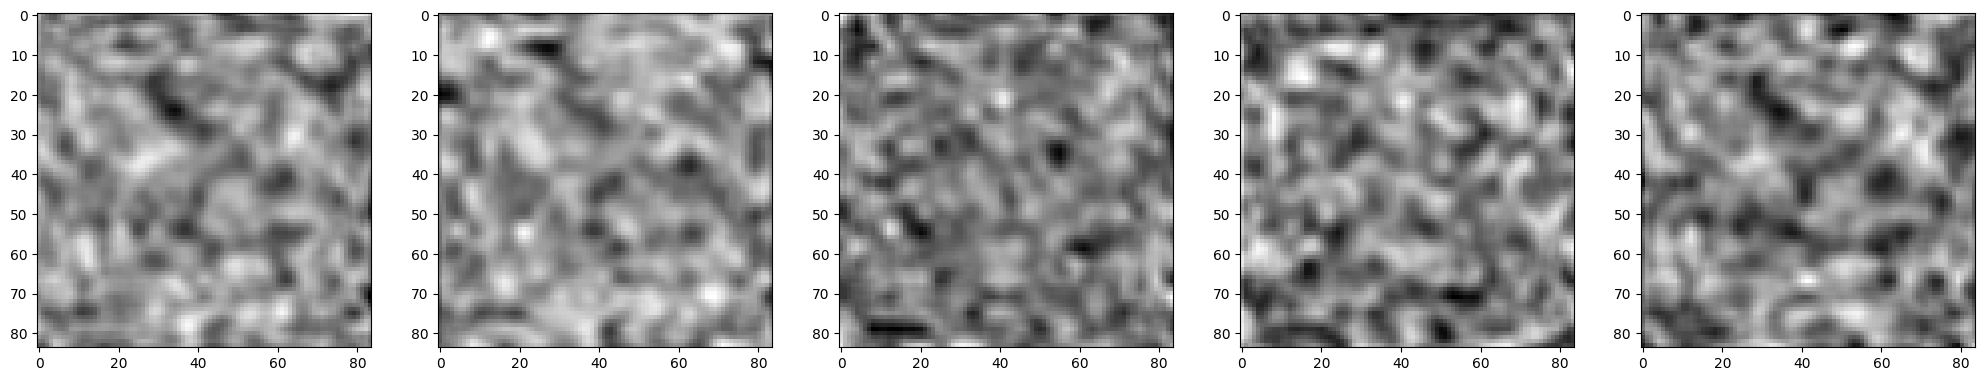

/tmp/ipython-input-1639551272.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = x + model.object_masks[idx, i, :].detach().numpy()


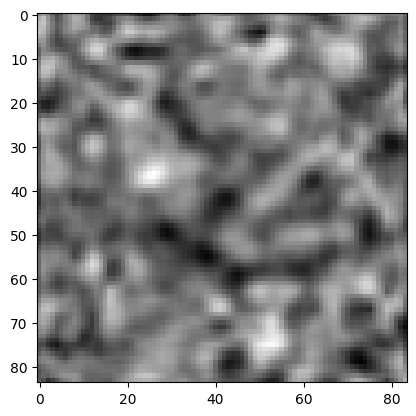

In [ ]:
import random

# test model
model_path = './skills/vid-obj-seg.pt'
model.load_state_dict(torch.load(model_path))
inference_device = "cpu"
model = VideoObjectSegmentationModel(device=inference_device)
model.to(inference_device)
model.eval()

data = VOSDataset(batch_size, num_frames, data_path)
inp = data.get_batch("train").to(inference_device)
inp = torch.cat([torch.unsqueeze(inp[:, 0, :, :], 1), torch.unsqueeze(inp[:, 0, :, :], 1)], 1)
x0_ = model(inp)
x0 = torch.unsqueeze(inp[:, 0, :, :], 1)
x1 = torch.unsqueeze(inp[:, 1, :, :], 1)

fig, ax = plt.subplots(1, 4, figsize=(12, 4))

idx = 10

ax[0].imshow(x0[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[1].imshow(x1[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[2].imshow(x0_[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[3].imshow((x0[idx]-x1[idx]).permute([1, 2, 0]).detach().numpy(), cmap='gray')

plt.show()

num_f = 5
masks = model.object_masks
fig, ax = plt.subplots(1, num_f, figsize=(25, 15))
for i in range(num_f):
    ax[i].imshow(masks[idx, i, :].detach().numpy(), cmap='gray')

plt.show()

x = torch.zeros(84, 84)
for i in range(model.K):
    x = x + model.object_masks[idx, i, :].detach().numpy()
plt.imshow(x, cmap='gray')
plt.show()

## Video Object Keypoints

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, inp_ch=3):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(inp_ch, 32, 7, 1, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

    def forward(self, inp):
        out = self.encoder(inp)
        return out

class KeyNet(nn.Module):
    def __init__(self, inp_ch=3, K=1):
        super().__init__()

        self.keynet = nn.Sequential(
            nn.Conv2d(inp_ch, 32, 7, 1, 3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.reg = nn.Conv2d(128, K, 1)

    def forward(self, inp):
        x = self.keynet(inp)
        out = self.reg(x)
        return out

class RefineNet(nn.Module):
    def __init__(self, num_ch):
        super().__init__()

        self.refine_net = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(32, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, num_ch, 7, 1, 3),
            nn.BatchNorm2d(num_ch),
            nn.ReLU()
        )

    def forward(self, inp):
        out = self.refine_net(inp)
        return out

# https://github.com/ethanluoyc/transporter-pytorch/blob/master/transporter.py
def spatial_softmax(features):
    features_reshape = features.reshape(features.shape[:-2] + (-1,))
    output = F.softmax(features_reshape, dim=-1)
    output = output.reshape(features.shape)
    return output

def compute_keypoint_location_mean(features):
    S_row = features.sum(-1)  # N, K, H
    S_col = features.sum(-2)  # N, K, W

    # N, K
    u_row = S_row.mul(torch.linspace(-1, 1, S_row.size(-1), dtype=features.dtype, device=features.device)).sum(-1)
    # N, K
    u_col = S_col.mul(torch.linspace(-1, 1, S_col.size(-1), dtype=features.dtype, device=features.device)).sum(-1)
    return torch.stack((u_row, u_col), -1) # N, K, 2

def gaussian_map(features, std=0.2):
    # features: (N, K, H, W)
    width, height = features.size(-1), features.size(-2)
    mu = compute_keypoint_location_mean(features)  # N, K, 2
    mu_y, mu_x = mu[:, :, 0:1], mu[:, :, 1:2]
    y = torch.linspace(-1.0, 1.0, height, dtype=mu.dtype, device=mu.device)
    x = torch.linspace(-1.0, 1.0, width, dtype=mu.dtype, device=mu.device)
    mu_y, mu_x = mu_y.unsqueeze(-1), mu_x.unsqueeze(-1)

    y = torch.reshape(y, [1, 1, height, 1])
    x = torch.reshape(x, [1, 1, 1, width])

    inv_std = 1 / std
    g_y = torch.pow(y - mu_y, 2)
    g_x = torch.pow(x - mu_x, 2)
    dist = (g_y + g_x) * inv_std**2
    g_yx = torch.exp(-dist)

    return g_yx

def transport(source_keypoints, target_keypoints, source_features, target_features):
    out = source_features
    for s, t in zip(torch.unbind(source_keypoints, 1), torch.unbind(target_keypoints, 1)):
        out = (1 - s.unsqueeze(1)) * (1 - t.unsqueeze(1)) * out + t.unsqueeze(1) * target_features
    return out

class Transporter(nn.Module):
    def __init__(self, encoder, keynet, refinenet, std=0.1):
        super().__init__()

        self.encoder = encoder
        self.key_net = keynet
        self.refine_net = refinenet
        self.std = std

    def forward(self, source_img, target_img):
        # source img
        source_features = self.encoder(source_img)
        source_kn = self.key_net(source_img)
        source_kn = spatial_softmax(source_kn)
        source_keypoints = gaussian_map(source_kn, self.std)

        # target img
        target_features = self.encoder(target_img)
        target_kn = self.key_net(target_img)
        target_kn = spatial_softmax(target_kn)
        target_keypoints = gaussian_map(target_kn, self.std)

        # transport
        transport_features = transport(source_keypoints.detach(),
                                    target_keypoints,
                                    source_features.detach(),
                                    target_features)

        # RefineNet
        out = self.refine_net(transport_features)
        return out


In [ ]:
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, Sampler
import os
import random

class ObjectKeypointsDataset(Dataset):
    def __init__(self, path, ep=10, transform=None):
        super().__init__()
        self.path = path
        self.transform = transform
        self.ep = ep

        # PRE-CACHE directory structure to avoid repeated os.listdir() calls
        self.envs = os.listdir(self.path)
        self.episode_lengths = {}

        print("Caching episode lengths...")
        for env in self.envs:
            env_path = f"{self.path}/{env}"
            for n in range(1, ep + 1):
                ep_path = f"{env_path}/episode_{n}"
                if os.path.exists(ep_path):
                    length = len(os.listdir(ep_path))
                    self.episode_lengths[(env, n)] = length
        print(f"Cached {len(self.episode_lengths)} episodes")

    def __len__(self):
        return len(self.episode_lengths) * 100  # Approximate

    def __getitem__(self, index):
        n, env, t, tp1 = index

        imgt = Image.open(f"{self.path}/{env}/episode_{n}/{t}.png")
        imgtp1 = Image.open(f"{self.path}/{env}/episode_{n}/{tp1}.png")

        if self.transform is not None:
            imgt = self.transform(imgt)
            imgtp1 = self.transform(imgtp1)

        return imgt, imgtp1

    def get_trajectory(self, env, idx):
        max_ep_len = self.episode_lengths.get((env, idx), 0)
        images = [Image.open(f'{self.path}/{env}/episode_{idx}/{t}.png')
                  for t in range(max_ep_len)]
        return [self.transform(im) for im in images]


class ObjectKeypointsSampler(Sampler):
    def __init__(self, dataset, cache_size=10000):
        self.dataset = dataset
        self.envs = os.listdir(self.dataset.path)
        self.cache_size = cache_size

        # PRE-CACHE: Build episode metadata once
        print("Building episode metadata cache...")
        self.episode_metadata = []
        for env in self.envs:
            env_path = os.path.join(self.dataset.path, env)
            for n in range(1, self.dataset.ep + 1):
                episode_path = os.path.join(env_path, f"episode_{n}")
                if os.path.exists(episode_path):
                    num_images = len(os.listdir(episode_path))
                    if num_images >= 21:
                        self.episode_metadata.append({
                            'env': env,
                            'episode': n,
                            'length': num_images
                        })

        print(f"Cached {len(self.episode_metadata)} valid episodes")
        self._generate_samples()

    def _generate_samples(self):
        """Generate a batch of samples to avoid per-iteration overhead"""
        self.samples = []
        for _ in range(self.cache_size):
            metadata = random.choice(self.episode_metadata)
            num_images = metadata['length']

            t_ind = np.random.randint(0, num_images - 20)
            tp1_ind = t_ind + np.random.randint(1, min(20, num_images - t_ind) + 1)

            self.samples.append((
                metadata['episode'],
                metadata['env'],
                t_ind,
                tp1_ind
            ))

    def __iter__(self):
        idx = 0
        while True:
            if idx >= len(self.samples):
                self._generate_samples()
                idx = 0

            yield self.samples[idx]
            idx += 1

    def __len__(self):
        return self.cache_size

In [ ]:
import random
import numpy as np
import os
import sys
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader


IMG_SZ = 84
MAX_ITER = 1000000
batch_size = 32
image_channels = 1
K = 4
lr = 1e-3
lr_decay = 0.95
lr_decay_len = int(1e5)

# Ensure GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
encoder = Encoder(image_channels)
key_net = KeyNet(image_channels, K)
refine_net = RefineNet(image_channels)
transporter = Transporter(encoder, key_net, refine_net)
transporter = transporter.to(device)  # Move to GPU
transporter.train()

# Data augmentation & preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((IMG_SZ, IMG_SZ)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Setup datasets with caching
# NOTE: Replace 'data_path' and 'EPISODES' with your actual values
# data_path = "/path/to/your/data"
# EPISODES = 10

t_dataset = ObjectKeypointsDataset(data_path, EPISODES, transform=transform)
t_sampler = ObjectKeypointsSampler(t_dataset)

# CRITICAL: Use num_workers > 0 for parallel data loading
# pin_memory=True speeds up CPU->GPU transfer
t_data_loader = DataLoader(
    t_dataset,
    batch_size=batch_size,
    sampler=t_sampler,
    num_workers=2,  # Adjust based on your CPU cores
    pin_memory=True,  # Faster CPU->GPU transfer
    persistent_workers=True  # Keep workers alive between epochs
)

v_dataset = ObjectKeypointsDataset(data_path, EPISODES, transform=transform)
v_sampler = ObjectKeypointsSampler(v_dataset)
v_data_loader = DataLoader(
    v_dataset,
    batch_size=2*batch_size,
    sampler=v_sampler,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

# Optimizer
optimizer = torch.optim.Adam(transporter.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_decay_len, lr_decay)

Using device: cuda
Caching episode lengths...
Cached 500 episodes
Building episode metadata cache...
Cached 488 valid episodes
Caching episode lengths...
Cached 500 episodes
Building episode metadata cache...
Cached 488 valid episodes


In [ ]:
pbar = tqdm(enumerate(t_data_loader), total=MAX_ITER, desc="Training")
VAL_INTERVAL = 500
best_loss = 100
best_step = 0
eval_loss = 0.

for i, (xt, xtp1) in pbar:
    if i > MAX_ITER:
        break

    # Training step
    transporter.train()
    xt = xt.to(device, non_blocking=True)  # non_blocking for async transfer
    xtp1 = xtp1.to(device, non_blocking=True)

    optimizer.zero_grad()
    reconstruction = transporter(xt, xtp1)
    loss = F.mse_loss(reconstruction, xtp1)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Validation - only every VAL_INTERVAL steps
    if i % VAL_INTERVAL == 0:
        with torch.no_grad():
            transporter.eval()
            eval_losses = []

            for j, (xv, xv1) in enumerate(v_data_loader):
                if j >= 5:  # Average over 5 batches
                    break
                xv = xv.to(device, non_blocking=True)
                xv1 = xv1.to(device, non_blocking=True)
                r = transporter(xv, xv1)
                eval_losses.append(F.mse_loss(r, xv1).item())

            eval_loss = np.mean(eval_losses)

            if eval_loss < best_loss:
                best_loss = eval_loss
                best_step = i
                #torch.save(transporter.state_dict(), 'obj-key.pt')
                torch.save(transporter.state_dict(), './skills/vid-obj-key.pt')

    last_lr = scheduler.get_last_lr()[0]

    pbar.set_postfix({
        'train_loss': f'{loss.item():.4f}',
        'val_loss': f'{eval_loss:.4f}',
        'best_val': f'{best_loss:.4f}',
        'best_step': f'{best_step}',
        'lr': f'{last_lr:.2e}'
    })


Training:   3%|▎         | 28059/1000000 [47:41<27:32:02,  9.81it/s, train_loss=0.2635, val_loss=0.2576, best_val=0.2576, best_step=13000, lr=1.00e-03]


KeyboardInterrupt: 

In [ ]:
import random
import numpy as np
import os
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# ============= CONFIGURATION =============
IMG_SZ = 84
MAX_ITER = 1000000
batch_size = 64
image_channels = 1
K = 4
lr = 1e-3
lr_decay = 0.95
lr_decay_len = 1e5
VAL_INTERVAL = 500

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============= OPTIMIZED SAMPLER =============
class OptimizedObjectKeypointsSampler(Sampler):
    """Pre-cache episode lengths to avoid repeated I/O operations"""
    def __init__(self, dataset, cache_size=10000):
        self.dataset = dataset
        self.envs = os.listdir(self.dataset.path)
        self.cache_size = cache_size

        # PRE-CACHE: Build episode metadata once
        print("Building episode metadata cache...")
        self.episode_metadata = []
        for env in self.envs:
            env_path = os.path.join(self.dataset.path, env)
            for n in range(1, self.dataset.ep + 1):
                episode_path = os.path.join(env_path, f"episode_{n}")
                if os.path.exists(episode_path):
                    num_images = len(os.listdir(episode_path))
                    if num_images >= 21:
                        self.episode_metadata.append({
                            'env': env,
                            'episode': n,
                            'length': num_images
                        })

        print(f"Cached {len(self.episode_metadata)} valid episodes")
        self._generate_samples()

    def _generate_samples(self):
        """Generate a batch of samples to avoid per-iteration overhead"""
        self.samples = []
        for _ in range(self.cache_size):
            metadata = random.choice(self.episode_metadata)
            num_images = metadata['length']

            t_ind = np.random.randint(0, num_images - 20)
            tp1_ind = t_ind + np.random.randint(1, min(20, num_images - t_ind) + 1)

            self.samples.append((
                metadata['episode'],
                metadata['env'],
                t_ind,
                tp1_ind
            ))

    def __iter__(self):
        idx = 0
        while True:
            if idx >= len(self.samples):
                self._generate_samples()
                idx = 0

            yield self.samples[idx]
            idx += 1

    def __len__(self):
        return self.cache_size

# ============= MODEL SETUP =============
encoder = Encoder(image_channels)
key_net = KeyNet(image_channels, K)
refine_net = RefineNet(image_channels)
transporter = Transporter(encoder, key_net, refine_net)
transporter.to(device)
transporter.train()

# ============= DATA SETUP WITH OPTIMAL WORKERS =============
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((84, 84)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# CRITICAL: For large datasets without RAM cache, need MORE workers
# Rule of thumb: num_workers = min(batch_size // 4, cpu_count)
optimal_workers = min(max(batch_size // 4, 8), os.cpu_count() or 8)
print(f"Using {optimal_workers} workers for batch size {batch_size}")
print(f"Available CPUs: {os.cpu_count()}")

t_dataset = ObjectKeypointsDataset(data_path, EPISODES, transform=transform)
t_sampler = OptimizedObjectKeypointsSampler(t_dataset, cache_size=10000)
t_data_loader = DataLoader(
    t_dataset,
    batch_size,
    sampler=t_sampler,
    num_workers=optimal_workers,  # Scale with batch size
    pin_memory=True,
    prefetch_factor=4,  # Increased prefetch for larger batches
    persistent_workers=True  # Keep workers alive between epochs
)

v_dataset = ObjectKeypointsDataset(data_path, EPISODES, transform=transform)
v_sampler = OptimizedObjectKeypointsSampler(v_dataset, cache_size=1000)
v_data_loader = DataLoader(
    v_dataset,
    2*batch_size,
    sampler=v_sampler,
    num_workers=optimal_workers,
    pin_memory=True,
    persistent_workers=True
)

# ============= OPTIMIZATION SETUP =============
optimizer = torch.optim.Adam(transporter.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, int(lr_decay_len), lr_decay)

# Enable cudnn autotuner for optimal performance
torch.backends.cudnn.benchmark = True

# ============= TRAINING LOOP WITH THROUGHPUT TRACKING =============
best_loss = 100
best_step = 0
eval_loss = 0.

# Throughput tracking
samples_processed = 0
start_time = time.time()
step_times = []

pbar = tqdm(enumerate(t_data_loader), total=MAX_ITER, desc="Training")

for i, (xt, xtp1) in pbar:
    if i > MAX_ITER:
        break

    step_start = time.time()

    # Training step
    transporter.train()
    xt = xt.to(device, non_blocking=True)
    xtp1 = xtp1.to(device, non_blocking=True)

    optimizer.zero_grad(set_to_none=True)  # Faster than zero_grad()
    reconstruction = transporter(xt, xtp1)
    loss = F.mse_loss(reconstruction, xtp1)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Track throughput
    step_time = time.time() - step_start
    step_times.append(step_time)
    samples_processed += batch_size

    # Validation - only every VAL_INTERVAL steps
    if i % VAL_INTERVAL == 0:
        with torch.no_grad():
            transporter.eval()
            eval_losses = []

            for j, (xv, xv1) in enumerate(v_data_loader):
                if j >= 5:
                    break
                xv = xv.to(device, non_blocking=True)
                xv1 = xv1.to(device, non_blocking=True)
                r = transporter(xv, xv1)
                eval_losses.append(F.mse_loss(r, xv1).item())

            eval_loss = np.mean(eval_losses)

            if eval_loss < best_loss:
                best_loss = eval_loss
                best_step = i
                #torch.save(transporter.state_dict(), 'obj-key.pt')
                torch.save(transporter.state_dict(), f'./skills/vid-obj-key.pt')

        # Calculate throughput metrics
        if len(step_times) >= 100:
            avg_step_time = np.mean(step_times[-100:])
            throughput = batch_size / avg_step_time
            elapsed = time.time() - start_time
            overall_throughput = samples_processed / elapsed

            pbar.set_postfix({
                'train_loss': f'{loss.item():.4f}',
                'val_loss': f'{eval_loss:.4f}',
                'best_val': f'{best_loss:.4f}',
                'samp/s': f'{throughput:.1f}',  # Instantaneous
                'avg_samp/s': f'{overall_throughput:.1f}',  # Overall
                'step_ms': f'{avg_step_time*1000:.1f}',
                #'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })
    else:

        if len(step_times) >= 100:
            avg_step_time = np.mean(step_times[-100:])
            throughput = batch_size / avg_step_time

            pbar.set_postfix({
                'train_loss': f'{loss.item():.4f}',
                'val_loss': f'{eval_loss:.4f}',
                'samp/s': f'{throughput:.1f}',
                'step_ms': f'{avg_step_time*1000:.1f}',
                'lr': f'{scheduler.get_last_lr()[0]:.2e}'
            })

print(f"\nTraining complete! Best validation loss: {best_loss:.4f} at step {best_step}")
elapsed = time.time() - start_time
print(f"Total time: {elapsed/3600:.2f} hours")
print(f"Average throughput: {samples_processed/elapsed:.1f} samples/second")

xtp1 torch.Size([64, 1, 84, 84])
Encoder torch.Size([64, 128, 21, 21])
keypoints torch.Size([64, 4, 21, 21])
reconstruction torch.Size([64, 1, 84, 84])
locs torch.Size([4, 2])


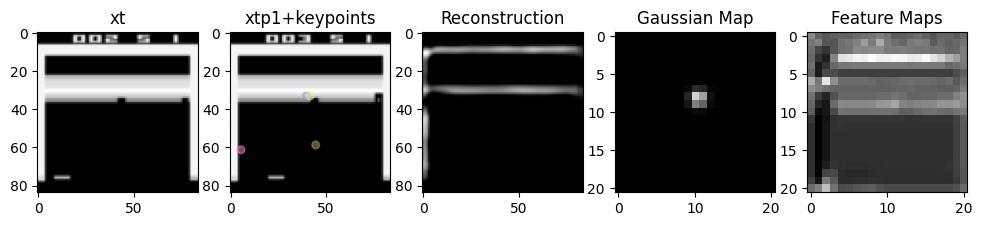

length 19
number of plots 7


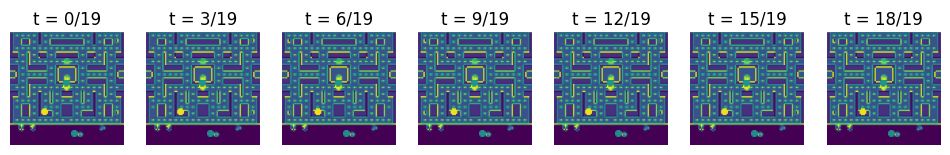

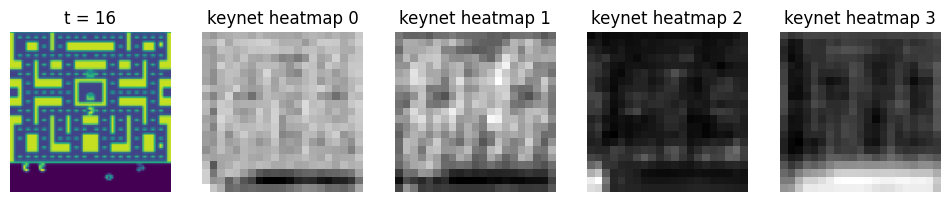

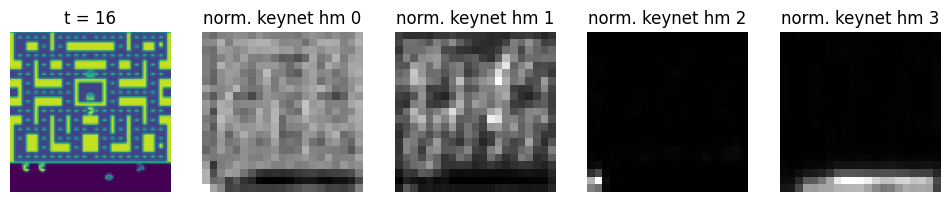

In [ ]:
from matplotlib.patches import Circle
from PIL import Image, ImageDraw

def generate_new_color(existing_colors, pastel_factor=0.5):
    max_distance = None
    best_color = None
    for i in range(0, 100):
        color = get_random_color(pastel_factor=pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color, c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color

def get_random_color(pastel_factor=0.5):
    return [(x + pastel_factor) / (1.0 + pastel_factor)
            for x in [np.random.uniform(0, 1.0) for i in [1, 2, 3]]]

def color_distance(c1, c2):
    return sum([abs(x[0] - x[1]) for x in zip(c1, c2)])

def get_n_colors(n, pastel_factor=0.9):
    colors = []
    for i in range(n):
        colors.append(generate_new_color(colors, pastel_factor=0.9))
    return colors

# test model
image_channels = 1
batch_size = 32
encoder = Encoder(image_channels)
k = 4 # number of keypoints, the same as in train_model.py
key_net = KeyNet(image_channels, k)
refine_net = RefineNet(image_channels)
model = Transporter(encoder, key_net, refine_net)
model_path = './skills/vid-obj-key.pt'
model.load_state_dict(torch.load(model_path))
model.to(inference_device)

v_dataset = ObjectKeypointsDataset(data_path, EPISODES, transform=transform)
v_sampler = ObjectKeypointsSampler(v_dataset)
v_data_loader = DataLoader(v_dataset, 2*batch_size, sampler=v_sampler)


model.eval()
for xt, xtp1 in v_data_loader:
    break

print("xtp1", xtp1.shape) #torch.Size([16, 3, 84, 84])

target_keypoints = model.key_net(xtp1)
reconstruction = model(xt, xtp1)

out1 = model.encoder(xtp1)
out2 = model.key_net(xtp1)
print("Encoder", out1.shape)
print("keypoints", out2.shape) #number of images * number of keypoints founded * width * height
print("reconstruction", reconstruction.shape)

fig, ax = plt.subplots(1, 5, figsize=(12, 4))
idx = 12
k_idx = 1
std = 0.1

feature_maps = spatial_softmax(target_keypoints)
gmap = gaussian_map(feature_maps, std)[idx, k_idx]

ax[0].imshow(xt[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[1].imshow(xtp1[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[2].imshow(reconstruction[idx].permute([1, 2, 0]).detach().numpy(), cmap='gray')
ax[3].imshow(gmap.detach().numpy(), cmap='gray', vmin=0, vmax=1)
ax[4].imshow(feature_maps[idx, k_idx].detach().numpy(), cmap='gray')

ax[0].title.set_text('xt')
ax[1].title.set_text('xtp1+keypoints')
ax[2].title.set_text('Reconstruction')
ax[3].title.set_text('Gaussian Map')
ax[4].title.set_text('Feature Maps')

locs = compute_keypoint_location_mean(
    spatial_softmax(model.key_net(xtp1)))[idx]

print("locs", locs.shape)

# set keypoints over image
colors = get_n_colors(len(locs))
for i, l in enumerate((locs + 1) / 2 * 80):
    ax[1].add_patch(Circle((l[1].item(), l[0].item()), 2,
                           color=colors[i], alpha=0.5))


plt.show()

def get_keypoints(model, source_images):
    return compute_keypoint_location_mean(
        spatial_softmax(model.key_net(source_images)))


def annotate_keypoints(img, kp_t, colors):
    draw = ImageDraw.Draw(img)

    for i, kp in enumerate(unnormalize_kp(kp_t, image_width)):
        y = kp.detach().numpy()[0]
        x = kp.detach().numpy()[1]
        r = 2

        draw.ellipse((x - r, y - r, x + r, y + r), colors[i][0])

    return img


def unnormalize_kp(kp, img_width):
    return (kp + 1) / 2 * img_width


episode = random.randint(1, EPISODES)
env = random.choice(os.listdir(data_path))
traj = torch.stack(v_dataset.get_trajectory(episode))
keypoints = get_keypoints(model, traj)
image_width = traj.size(-1)

fig = plt.figure(figsize=(12, 3))

colors = get_n_colors(k)
colors = [(int(color[0] * 255), int(color[1]*255), int(color[2]*255), 255) for color in colors]


trajectory_length = len([name for name in os.listdir(f"{data_path}/{env}/episode_{episode}") if os.path.isfile(os.path.join(f"{data_path}/{env}/episode_{episode}", name))])-1
steps = trajectory_length // 5
number_of_plots = (trajectory_length // steps) + 1
print("length", trajectory_length)
print("number of plots", number_of_plots)
for i, t in enumerate(range(0, trajectory_length, steps)):
    frame_t = traj[t].permute([1, 2, 0])
    kp_t = keypoints[t]
    frame_t = (frame_t.detach().numpy() * 255).astype('uint8')[:, :, 0]
    im = Image.fromarray(frame_t)
    annotate_keypoints(im, kp_t, colors)
    im = np.array(im)
    ax = fig.add_subplot(1, number_of_plots, i + 1)
    ax.imshow(im)
    ax.set_axis_off()
    ax.set_title(f't = {t}/{trajectory_length}')

plt.show()


traj = torch.stack(v_dataset.get_trajectory(episode))
keypoints = get_keypoints(model, traj)
image_width = traj.size(-1)

def get_heatmaps(model, source_images, normalize=True):
    if normalize:
        return spatial_softmax(model.key_net(source_images))
    return model.key_net(source_images)




fig, ax = plt.subplots(1, k+1, figsize=(12, 3))

idx = 16

ax[0].imshow(traj[idx].permute([1, 2, 0]).detach().numpy())
ax[0].set_axis_off()
ax[0].set_title(f't = {idx}')

hm = get_heatmaps(model, traj, normalize=False)[idx].detach().numpy()

for i, m in enumerate(hm):
    ax[i+1].imshow(m, cmap='gray')
    ax[i+1].set_axis_off()
    ax[i+1].set_title(f'keynet heatmap {i}')

plt.show()

fig, ax = plt.subplots(1, k+1, figsize=(12, 3))

idx = 16

ax[0].imshow(traj[idx].permute([1, 2, 0]).detach().numpy())
ax[0].set_axis_off()
ax[0].set_title(f't = {idx}')

hm = get_heatmaps(model, traj, normalize=True)[idx].detach().numpy()

for i, m in enumerate(hm):
    ax[i+1].imshow(m, cmap='gray')
    ax[i+1].set_axis_off()
    ax[i + 1].set_title(f'norm. keynet hm {i}')

plt.show()

In [ ]:
del fig, ax, model
import gc
gc.collect()

45565

## Frame Prediction

In [ ]:
import torch.nn as nn

class FramePredictionModel(nn.Module):
    def __init__(self, input_channels=4):
        super(FramePredictionModel, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1), #nella nature cnn stride = 2 kernel_size = 4, così ottengo feature maps di 16x16
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=8, stride=4),
            nn.Sigmoid()  # Sigmoid to ensure pixel values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt


class Dataset(Dataset):
    def __init__(self, path, idxs):
        super().__init__()
        self.path = path
        self.idxs = idxs
        self.envs = os.listdir(self.path)
    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        num_images = 0
        while num_images < 10:
            env = random.choice(self.envs)
            #TODO COMPLETE
            episode_index = np.random.choice(self.idxs)
            num_images = len(os.listdir(self.path + f"/{episode_index}"))

        start_index = np.random.randint(4, num_images - 5)
        new_frame = start_index + 5

        frames = []
        for i in range(3, -1, -1):
            img = np.array(Image.open(f"{self.path}/{episode_index}/{start_index - i}.png"))
            img = img / 255.0
            img = torch.from_numpy(img).contiguous().float()
            frames.append(img)

        frames = torch.stack(frames, dim=0)
        new_frame = np.array(Image.open(f"{self.path}/{episode_index}/{new_frame}.png"))
        new_frame = new_frame / 255.0
        new_frame = torch.from_numpy(new_frame).contiguous().float()
        new_frame = new_frame.unsqueeze(0)
        return frames, new_frame

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
import torch
import os
import numpy as np
import argparse
from torchvision import transforms


SAVE_MODEL_PATH = '/content/skills/frame-pred.pt'
data_path = f"/content/data"

#EPISODES
img_sz = 84
batch_size = 32

eps = np.arange(start=1, stop=EPISODES + 1)
np.random.shuffle(eps)
split_idx = int(EPISODES * 0.8)
train_idxs = eps[:split_idx]
val_idxs = eps[split_idx:EPISODES]

dataset_ts = Dataset(path=data_path, idxs=train_idxs)
train_load = DataLoader(dataset_ts, batch_size, num_workers=8)

dataset_vs = Dataset(path=data_path, idxs=val_idxs)
val_load = DataLoader(dataset_ts, batch_size, num_workers=8)

# Initialize the autoencoder model
model = FramePredictionModel(input_channels=4).to(device)
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Total params: {pytorch_total_params}") #forse un po troppi parametri


# Define loss function and optimizer
criterion = torch.nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_loss = 1000

# Training loop
num_epochs = 1200 * len(train_load)
for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for i, (frames, new_frame) in enumerate(train_load):

        optimizer.zero_grad()
        frames = frames.to(device)
        new_frame = new_frame.to(device)

        # Forward pass
        outputs = model(frames)

        # Compute loss and optimize
        train_loss = criterion(outputs, new_frame)
        train_losses.append(train_loss.item())
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    avg_train_loss = sum(train_losses) / len(train_losses)

    val_losses = []
    with torch.no_grad():
        model.eval()
        for i, (frames, new_frame) in enumerate(train_load):
            new_frame = new_frame.to(device)
            frames = frames.to(device)
            out = model(frames)
            val_loss = criterion(out, new_frame)
            val_losses.append(val_loss.item())

    avg_val_loss = sum(val_losses) / len(val_losses)

    if avg_val_loss < best_loss:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.7f}, Val Loss: {avg_val_loss:.7f}")
        best_loss = avg_val_loss
        #torch.save(model.state_dict(), os.path.join(SAVE_MODELS_DIR, save_name + '-frame-prediction.pt'))
        torch.save(model.state_dict(), f'./{save_name}-frame-prediction.pt')

In [ ]:
import numpy as np
import torch
import os
import sys
import random
import torch.nn.functional as F

num_frames = 2
batch_size = 32
steps = 1000000
lr = 1e-4
max_grad_norm = 5.0

data = VOSDataset(batch_size, num_frames, data_path)
inp = data.get_batch("train").to(device)


model = VideoObjectSegmentationModel(device=device)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
lamb = lambda epoch : 1 - epoch/steps
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lamb)

best_val_loss = 1.
for i in range(steps):
    model.train()
    optimizer.zero_grad()
    inp = data.get_batch("train").to(device)
    x0_ = model(inp)
    x0 = torch.unsqueeze(inp[:, 0, :, :], 1)
    tr_loss = model.compute_loss(x0, x0_)
    tr_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()

    with torch.no_grad():
        model.eval()
        inp = data.get_batch("val").to(device)
        x0_ = model(inp)
        x0 = torch.unsqueeze(inp[:, 0, :, :], 1)
        val_loss = model.compute_loss(x0, x0_)

    model.update_reg()

    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        print(f"Step: {i} new best val_loss : {val_loss}")
        torch.save(model.state_dict(), f'./skills/vid-obj-seg.pt')


    last_lr = scheduler.get_last_lr()[0]


## Unsupervised State Representation

In [ ]:
%%capture
import ale_py
roms_path = ale_py.roms.__path__
!python -m atari_py.import_roms {roms_path[0]}

In [ ]:
import torch
from atariari.benchmark.episodes import get_episodes
from atariari.methods.encoders import NatureCNN
from atariari.methods.stdim import InfoNCESpatioTemporalTrainer

all_tr_eps = []
all_val_eps = []

for env_name in ENVS:
    print(f"Collecting episodes from {env_name}...")
    tr_eps, val_eps = get_episodes(
        steps=100000,
        env_name=env_name,
        collect_mode="random_agent",
        train_mode="train_encoder",
    )

    all_tr_eps.extend(tr_eps)
    all_val_eps.extend(val_eps)
    print(f"  Train episodes: {len(tr_eps)}, Val episodes: {len(val_eps)}")

print(f"\nTotal train episodes: {len(all_tr_eps)}")
print(f"Total val episodes: {len(all_val_eps)}")

# Shuffle the episodes
random.shuffle(all_tr_eps)
random.shuffle(all_val_eps)

print("Episodes shuffled!")


-------Collecting samples----------


KeyboardInterrupt: 

In [ ]:
class Args:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

class DummyWandB:
    class Run:
      def __init__(self):
          self.dir = "/content/skills"

    def __init__(self):
        self.run = self.Run()
    def log(self, *args, **kwargs):
        pass

    def watch(self, *args, **kwargs):
        pass

    def finish(self):
        pass

dummy_wandb = DummyWandB()
args = {
    #"env_name": "MsPacmanNoFrameskip-v4",
    "pretraining_steps": 10000,
    "no_downsample": True,
    "probe_collect_mode": "random_agent",
    "feature_size":512,
    "end_with_relu":True,
    "encoder_type":"Nature",
    "patience": 15,
    "epochs": 100,
    "batch_size": 64,
    "lr": 3e-4,
    "method": "vae",
    "end_with_relu":False,
    "wandb": dummy_wandb,
}

args = Args(**args)

observation_shape = all_tr_eps[0][0].shape
encoder = NatureCNN(observation_shape[0], args)

config = {}
config.update(vars(args))
config['obs_space'] = observation_shape
trainer = InfoNCESpatioTemporalTrainer(encoder, config, device=device, wandb=dummy_wandb)
trainer.train(all_tr_eps, all_val_eps)

Total Steps: 4179
Train Epoch: 0, Epoch Loss: 6.714060196509728, Train
Total Steps: 627
Val Epoch: 0, Epoch Loss: 6.24921793407864, Val
Total Steps: 4179


KeyboardInterrupt: 

In [ ]:
from atariari.methods.stdim import InfoNCESpatioTemporalTrainer

# Monkey patch the log_results method
original_log_results = InfoNCESpatioTemporalTrainer.log_results

def patched_log_results(self, epoch_idx, epoch_loss1, epoch_loss2, epoch_loss, prefix):
    print("{} Epoch: {}, Epoch Loss: {}, {}".format(
        prefix.capitalize(), epoch_idx, epoch_loss, prefix.capitalize()
    ))

    # Only log if wandb is not None
    if self.wandb is not None:
        self.wandb.log({
            prefix + '_loss': epoch_loss,
            prefix + '_loss1': epoch_loss1,
            prefix + '_loss2': epoch_loss2
        }, step=epoch_idx, commit=False)

InfoNCESpatioTemporalTrainer.log_results = patched_log_results

In [ ]:
import wandb
import torch
from atariari.methods.utils import get_argparser
from atariari.benchmark.episodes import get_episodes
from atariari.methods.encoders import NatureCNN
from atariari.methods.stdim import InfoNCESpatioTemporalTrainer

def train_encoder(args):
    device = torch.device("cuda:" + str(args.cuda_id) if torch.cuda.is_available() else "cpu")
    tr_eps, val_eps = get_episodes(steps=args.pretraining_steps,
                                 env_name=args.env_name,
                                 seed=args.seed,
                                 num_processes=args.num_processes,
                                 num_frame_stack=args.num_frame_stack,
                                 downsample=not args.no_downsample,
                                 color=args.color,
                                 entropy_threshold=args.entropy_threshold,
                                 collect_mode=args.probe_collect_mode,
                                 train_mode="train_encoder",
                                 checkpoint_index=args.checkpoint_index,
                                 min_episode_length=args.batch_size)

    observation_shape = tr_eps[0][0].shape
    if args.encoder_type == "Nature":
        encoder = NatureCNN(observation_shape[0], args)
    else:
        assert False, "method {} has no trainer".format(args.method)

    encoder.to(device)
    torch.set_num_threads(1)

    config = {}
    config.update(vars(args))
    config['obs_space'] = observation_shape
    trainer = InfoNCESpatioTemporalTrainer(encoder, config, device=device, wandb=wandb)
    trainer.train(tr_eps, val_eps)

    return encoder

parser = get_argparser()
args = parser.parse_args()
tags = ['pretraining-only', 'state_rep']
wandb.init(project=args.wandb_proj, entity="epai", tags=tags)
config = {}
config.update(vars(args))
wandb.config.update(config)
train_encoder(args)

# nohup python main.py --env-name PongNoFrameskip-v4 --num-frame-stack 4  --num-processes 1 --feature-size 512 --wandb-proj attskills --train-encoder > statepong#1.log 2>&1 &